In [11]:
# this is only for MacOS M-series chips
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile
import librosa
import torch
import wavmark
import time
from IPython.display import Audio, display

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Arial'



def text_to_binary(text):
    return [format(ord(char), '08b') for char in text]

def binary_to_text(binary_list):
    try:
        text = ''.join(chr(int(b, 2)) for b in binary_list)
        return text
    except ValueError:
        raise ValueError("Input should be a space-separated string of 8-bit binary numbers.")


EMBEDDED_TEXT = "Tchaikovsky"
AUDIO_PATH = "data/tchaikovsky_symphony5_movement4_theme_single.wav"

In [2]:
# 1. load model
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")
model = wavmark.load_model("wavmark_params/step59000_snr39.99_pesq4.35_BERP_none0.30_mean1.81_std1.81.model.pkl").to(device)

In [3]:
# 2.create 16-bit payload
# if EMBEDDED_TEXT is odd, add a space to the end
if len(EMBEDDED_TEXT) % 2 == 1:
    EMBEDDED_TEXT += " "
binary_list = text_to_binary(EMBEDDED_TEXT)

payload_list = []
for i in np.arange(0,len(EMBEDDED_TEXT),2):
    payload_list.append(np.concatenate((
        np.array(list(binary_list[i]),dtype=np.int64),
        np.array(list(binary_list[i+1]),dtype=np.int64)
    )))
print("Information:", binary_to_text(binary_list))
print("Text length:", len(binary_list))

Information: Tchaikovsky 
Text length: 12


In [4]:
# 3.1. read host audio
# the audio should be a single-channel 16kHz wav, you can read it using soundfile:
signal, sampling_rate = soundfile.read(AUDIO_PATH)
# display(Audio(data=signal, rate=sampling_rate, autoplay=True))

# 3.2. segmentation and encode
audio_length = len(signal)/sampling_rate
audio_length_int = np.int64(audio_length//1)
print("Audio length left:", audio_length, "s")

# segment the audio to clips
signal_clips = [signal[i*sampling_rate:(i+2)*sampling_rate] for i in np.arange(0,audio_length_int,2)]  # 2s clips
print("Number of clips left:", len(signal_clips))
print("Maximum number of encoded ASCII characters:", len(signal_clips)*2)

original_signal = np.concatenate(signal_clips)
display(Audio(data=original_signal, rate=sampling_rate, autoplay=True))



Audio length left: 15.002993197278911 s
Number of clips left: 8
Maximum number of encoded ASCII characters: 16


In [6]:
# 4. encode the payload

encoded_signal_clips = []
for i in range(len(signal_clips)):
    if i < len(payload_list):
        watermarked_signal, _ = wavmark.encode_watermark(model, signal_clips[i], payload_list[i])
        encoded_signal_clips.append(watermarked_signal)
    else:
        encoded_signal_clips.append(signal_clips[i])
encoded_signal = np.concatenate(encoded_signal_clips, axis=0)

soundfile.write("data/output.wav", encoded_signal, sampling_rate)
display(Audio(data=encoded_signal, rate=sampling_rate, autoplay=True))


/Users/zuricho/anaconda3/envs/audio/lib/python3.10/site-packages/torch/functional.py:660: UserWarning: The operator 'aten::_fft_r2c' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


skip section:2, snr too low:20.0
skip section:3, snr too low:20.0
skip section:4, snr too low:20.0
skip section:2, snr too low:20.0
skip section:1, snr too low:20.0
skip section:2, snr too low:20.0


In [7]:
# 5. decode watermark

encoded_signal_clips

payload_decoded_list = []

for i in range(len(encoded_signal_clips)):
    payload_decoded, _ = wavmark.decode_watermark(model, encoded_signal_clips[i], show_progress=True)
    payload_decoded_list.append(payload_decoded)

    
# BER = ((payload_list[0]) != payload_decoded).mean() * 100

# print("Decode BER:%.1f" % BER)

100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


In [8]:
# 6. print output
payload_decoded_list

text_decoded_binary_list = []
for i in range(len(payload_decoded_list)):
    if payload_decoded_list[i] is not None:
        text_decoded_binary_list.append("".join([str(bit) for bit in payload_decoded_list[i][0:8]]))
        text_decoded_binary_list.append("".join([str(bit) for bit in payload_decoded_list[i][8:16]]))

binary_to_text(text_decoded_binary_list)

'Tchaikovsky '

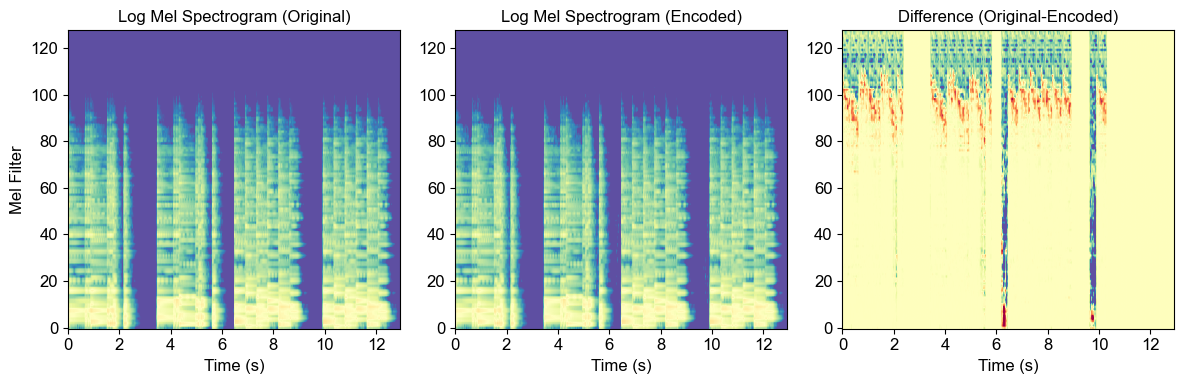

In [43]:
# 7. plot mel spectrogram
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
mel_sp_original = librosa.feature.melspectrogram(y=original_signal, sr=sampling_rate)
plt.imshow(np.log10(mel_sp_original), origin='lower', aspect='auto', cmap='Spectral_r', vmin=-5, vmax=5)


plt.xticks(np.arange(0, 1300, 200), np.arange(0, np.int64(1300/100), 2))
plt.title('Log Mel Spectrogram (Original)', fontsize=12)
plt.xlabel('Time (s)')
plt.ylabel('Mel Filter')
# plt.colorbar(label='Magnitude (dB)')

plt.subplot(1, 3, 2)
mel_sp_encoded = librosa.feature.melspectrogram(y=encoded_signal, sr=sampling_rate)
plt.imshow(np.log10(mel_sp_encoded), origin='lower', aspect='auto', cmap='Spectral_r', vmin=-5, vmax=5)

plt.xticks(np.arange(0, 1300, 200), np.arange(0, np.int64(1300/100), 2))
plt.title('Log Mel Spectrogram (Encoded)', fontsize=12)
plt.xlabel('Time (s)')


plt.subplot(1, 3, 3)
plt.imshow(np.log10(mel_sp_original) - np.log10(mel_sp_encoded), origin='lower', aspect='auto', cmap='Spectral_r', vmin=-2, vmax=2)

plt.xticks(np.arange(0, 1300, 200), np.arange(0, np.int64(1300/100), 2))
plt.title('Difference (Original-Encoded)', fontsize=12)
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig("figure/mel_spectrogram.png", dpi=300)